# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T (http://www.liaad.up.pt/area/fanaee) at the University of Porto (https://up.pt/) compiled this data into a CSV file, which I'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's website (http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In this project, I will be attempting to predict the number of bikes rented in a given hour.  In this data set, this value is recorded in the 'cnt' column.  This will be accomplished by running several machine learning models and evaluating how well they are able to fit the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Explaination of Columns

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

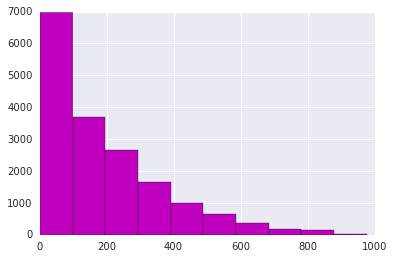

In [3]:
plt.hist(bike_rentals.cnt,color='m')

Above is a histogram of bike rentals per hour.  It is seen here that the majority of the time the number of bikes that are rented is between 0 and 100.

In [4]:
bike_rentals.corr().cnt.sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Seen above are the correlation coefficients of each column and the 'cnt' column.  This will be helpful when selecting which features will be used to train our machine learning model.

# Feature Calculation

It can often be helpful to calculate features before applying machine learning models.  Features can enhance the accuracy of models by introducing new information, or distilling existing information.

In [5]:
bins = [0,6,12,18,24]
group_names = [4,1,2,3]
bike_rentals['time_label'] = pd.cut(bike_rentals['hr'],bins,labels=group_names)
bike_rentals['time_label'].fillna(4,inplace=True)

In the above cell, the 'hr' column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. I introduced some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

The following was placed in the column 'time_label':

- 1 if the hour is from 6 to 12 (morning)
- 2 if the hour is from 12 to 18 (afternoon)
- 3 if the hour is from 18 to 24 (evening)
- 4 if the our is from 0 to 6 (night)


In [6]:
#Below is the first five rows of the new dataframe
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


The 'cnt' column contains continuous values therefore we are dealing with a regression problem.  Becasue of this, the error metric I am choosing to use is mean squared error.  This is because mean squared error emphasizes larger errors over smaller ones.  

# Train Test Split

In [7]:
columns = list(bike_rentals.columns.drop(['cnt','casual','dteday','registered']))
x = bike_rentals[columns]
y = bike_rentals['cnt']
#80-20% train test split
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=.8,random_state=1)

In [8]:
columns

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

# Applying Linear Regression

Linear regression will porbably work fairly well on this data, given that many of the columns are highly correlated with 'cnt'.
Linear regression works best when predictors are linearly correlated to the target and also independent -- meaning features dont change meaning when coupled with other features.
I'll need to ignore the 'casual' and 'registered' columns because 'cnt' is derived from them. 'cnt' is just 'casual' and 'registered' summed together.  I am trying to discover the number of bike rentals ('cnt'), because of this, it would not make sense that I know the values of either 'casual' or 'registered'

In [9]:
lr = LinearRegression()
lr.fit(x_train,y_train)
test_predictions = lr.predict(x_test)
train_predictions = lr.predict(x_train)
test_mse = mean_squared_error(y_test,test_predictions)
train_mse = mean_squared_error(y_train,train_predictions)
print('test_mse={} \ntrain_mse={}'.format(test_mse,train_mse))
print('test_score={}'.format(lr.score(x_train,y_train)))
print('train_score={}'.format(lr.score(x_train,y_train)))

test_mse=16228.642597902513 
train_mse=16167.279508117941
test_score=0.5068405963840535
train_score=0.5068405963840535


In [10]:
print(lr.coef_)
print(lr.intercept_)


[-7.97281923e-03  2.10748344e+01  1.53004912e+02  5.11882535e+00
  5.33929015e+00 -2.62608075e+01  2.11121260e+00  4.33652495e+00
 -1.77484394e+01  5.96736264e+01  2.21054043e+02 -1.21715363e+02
  3.70279788e+00 -5.89873681e+01]
140.5406227576509


# Evaluation
The Linear Regression model shown above appears to have a very poor ability to predict data.  The problem is most likely underfitting because the train and test predictions are very similar.

# Applying Decision Tree Regressor

In [47]:
dt = DecisionTreeRegressor(min_samples_leaf=5,min_samples_split=20,)
dt.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=20,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [49]:
predictions_dt = dt.predict(x_test)

print(mean_squared_error(y_test,predictions_dt))
print(dt.score(x_test,y_test))

2389.6485538515435
0.9283719661559348


# Decision tree error

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression

# Applying Random Forest Regressor

In [64]:
rf = RandomForestRegressor(min_samples_leaf=3,min_samples_split=4)
rf.fit(x_train,y_train)
predictions_rf = rf.predict(x_test)
print(mean_squared_error(y_test,predictions_rf))
print(rf.score(x_test,y_test))

1730.8772529518951
0.9481181723335275


# Random Forests Error

 Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf. In this case, random forests is clearly the winner.

In [68]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4
